In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import gdreg
import matplotlib.pyplot as plt
import pickle

In [2]:
DATA_PATH = '/n/groups/price/martin/WES_analysis/toy_1K'
SIMU_LIST = ['sanity_nd', 'sanity']
DIC_SIMU = {}
DIC_SIMU['sanity'] = {
    'truth' : DATA_PATH + '/sanity_rep@.eff_sum',
    'res' : DATA_PATH + '/results/reg/sanity_rep@',
}
DIC_SIMU['sanity_nd'] = {
    'truth' : DATA_PATH + '/sanity_nd_rep@.eff_sum',
    'res' : DATA_PATH + '/results/reg/sanity_nd_rep@',
}
N_REP = 20
MAX_ITER = 11

### Read results 

In [3]:
# Read results 
dic_res = {}
for simu in DIC_SIMU:
    dic_res[simu] = {}
    for i_rep in range(N_REP):
        dic_res[simu]['%d.truth'%i_rep] = pd.read_csv(
            DIC_SIMU[simu]['truth'].replace('@','%d'%i_rep), sep='\t', index_col=0
        )
        dic_res[simu]['%d.res'%i_rep] = pd.read_csv(
            DIC_SIMU[simu]['res'].replace('@','%d'%i_rep)+'.tsv', sep='\t', index_col=0
        )
        for i_iter in range(MAX_ITER):
            file_name = DIC_SIMU[simu]['res'].replace('@','%d'%i_rep)+'_res%d.tsv'%i_iter
            if os.path.exists(file_name):
                dic_res[simu]['%d.res%d'%(i_rep, i_iter)] = pd.read_csv(file_name, sep='\t', index_col=0)


### Analysis

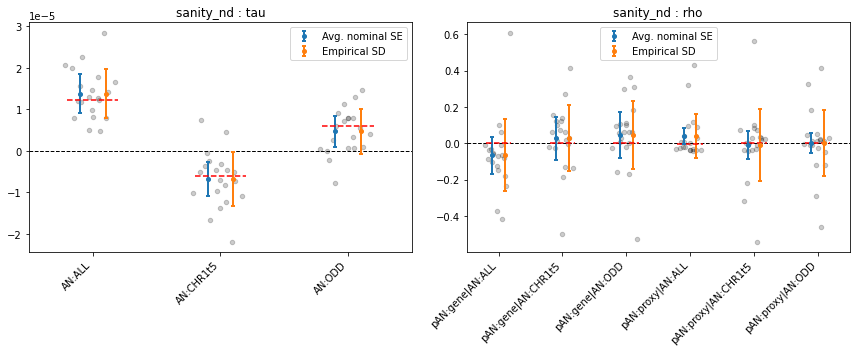

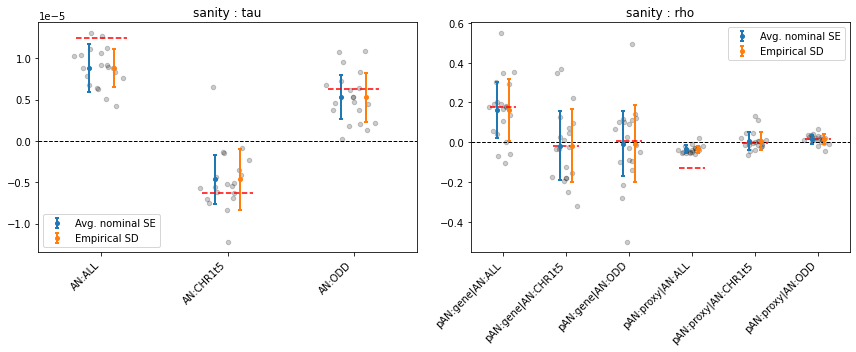

In [4]:
# Check calibration : tau
annot_list = ['AN:ALL', 'AN:CHR1t5', 'AN:ODD']
pannot_list = ['pAN:gene', 'pAN:proxy']
v_jitter = np.random.randn(N_REP)*0.1

for simu in SIMU_LIST:
    plt.figure(figsize=[12,5])
    
    # tau
    plt.subplot(1,2,1)
    v_tau_mean = []
    v_tau_se_nom = []
    v_tau_se_empi = []
    v_tau_true_mean = []
    for i_AN,AN in enumerate(annot_list):
        v_tau = np.array([dic_res[simu]['%d.res'%x].loc[AN, 'tau'] for x in range(N_REP)])
        v_tau_se = np.array([dic_res[simu]['%d.res'%x].loc[AN, 'tau_se'] for x in range(N_REP)])
        v_tau_true = np.array([dic_res[simu]['%d.truth'%x].loc[AN, 'tau'] for x in range(N_REP)])
        
        v_tau_mean.append(v_tau.mean())
        v_tau_se_nom.append(v_tau_se.mean())
        v_tau_se_empi.append(v_tau.std())
        tau_true = v_tau_true.mean()

        plt.scatter(v_jitter+i_AN, v_tau, alpha=0.2, color='k', s=20)
        plt.plot([i_AN-0.2, i_AN+0.2], [tau_true, tau_true], '--', color='r', )
        
    # CIs
    plt.errorbar(
        np.arange(len(annot_list))-0.1, v_tau_mean, yerr=v_tau_se_nom, fmt='o', markersize=4,
        elinewidth=2, capsize=2, capthick=2, label='Avg. nominal SE'
    )
    plt.errorbar(
        np.arange(len(annot_list))+0.1, v_tau_mean, yerr=v_tau_se_empi, fmt='o', markersize=4,
        elinewidth=2, capsize=2, capthick=2, label='Empirical SD'
    )
    
    plt.plot([-0.5, len(annot_list)-0.5], [0, 0], '--', color='k', linewidth=1, zorder=0)
    plt.xlim([-0.5, len(annot_list)-0.5])
    plt.title('%s : tau' % simu)
    plt.legend()
    plt.xticks(np.arange(len(annot_list)), annot_list, rotation=45, ha='right')
    
    # rho
    plt.subplot(1,2,2)
    plot_list = ['%s|%s'%(x,y) for x in pannot_list for y in annot_list]
    v_rho_mean = []
    v_rho_se_nom = []
    v_rho_se_empi = []
    v_rho_true_mean = []
        
    for i_plot,term in enumerate(plot_list):
        pAN,AN = term.split('|')
        
        v_rho = np.array([dic_res[simu]['%d.res'%x].loc[AN, 'rho|%s'%pAN] for x in range(N_REP)])
        v_rho_se = np.array([dic_res[simu]['%d.res'%x].loc[AN, 'rho_se|%s'%pAN] for x in range(N_REP)])
        v_rho_true = np.array([dic_res[simu]['%d.truth'%x].loc[AN, 'rho|%s'%pAN] for x in range(N_REP)])

        v_rho_mean.append(v_rho.mean())
        v_rho_se_nom.append(v_rho_se.mean())
        v_rho_se_empi.append(v_rho.std())
        rho_true = v_rho_true.mean()

        plt.scatter(v_jitter+i_plot, v_rho, alpha=0.2, color='k', s=20)
        plt.plot([i_plot-0.2, i_plot+0.2], [rho_true, rho_true], '--', color='r', )
        
    # CIs
    plt.errorbar(
        np.arange(len(v_rho_mean))-0.1, v_rho_mean, yerr=v_rho_se_nom, fmt='o', markersize=4,
        elinewidth=2, capsize=2, capthick=2, label='Avg. nominal SE'
    )
    plt.errorbar(
        np.arange(len(v_rho_mean))+0.1, v_rho_mean, yerr=v_rho_se_empi, fmt='o', markersize=4,
        elinewidth=2, capsize=2, capthick=2, label='Empirical SD'
    )
    
    plt.plot([-0.5, len(plot_list)-0.5], [0, 0], '--', color='k', linewidth=1, zorder=0)
    plt.xlim([-0.5, len(plot_list)-0.5])
    plt.title('%s : rho' % simu)
    plt.legend()
    plt.xticks(np.arange(len(plot_list)), plot_list, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
#     break


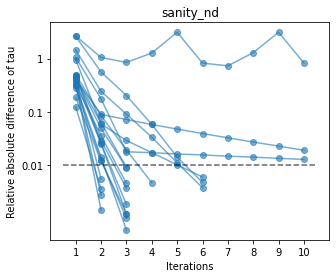

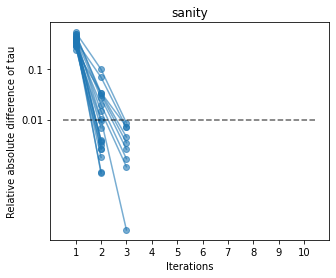

In [26]:
# Convergence 
for simu in SIMU_LIST:
    plt.figure(figsize=[5,4])
    for i_rep in range(N_REP):
        v_rel_dif = []
        for i_iter in range(1, MAX_ITER):
            if '%d.res%d'%(i_rep,i_iter) not in dic_res[simu]:
                continue
            v_tau = dic_res[simu]['%d.res%d'%(i_rep,i_iter)]['tau']
            v_tau_prev = dic_res[simu]['%d.res%d'%(i_rep,i_iter-1)]['tau']
            v_rel_dif.append(np.absolute(v_tau - v_tau_prev).sum() / np.absolute(v_tau).sum())
        v_rel_dif = np.array(v_rel_dif, dtype=float)
        plt.plot(np.arange(len(v_rel_dif))+1, np.log10(v_rel_dif), '-o', alpha=0.6, color='C0')
        
    plt.xticks(np.arange(1, MAX_ITER), np.arange(1, MAX_ITER))
    plt.xlabel('Iterations')
    plt.yticks(np.log10([0.01, 0.1, 1, 5]), ['%0.1g'%x for x in [0.01, 0.1, 1, 5]])
    plt.ylabel('Relative absolute difference of tau')
    plt.plot([0.5, MAX_ITER-0.5], np.log10([0.01, 0.01]), '--', color='k', alpha=0.6)
    plt.title(simu)
    plt.show()
